### Importing packages

In [22]:
from stock_holder import StockHolder

### Defining some parameters

In [23]:
MOVING_AVERAGE_PAIRS = [(4, 8), (3, 5), (10, 20), (10, 30)]

INITIAL_CASH = 100,000
MARKET_COMMISSION = 0.01

SAMPLE_STOCK_NAME = 'MAPNA'

### Reading sample data

In [24]:
stock_holder = StockHolder()

### data stats view

stock stats:
<bound method NDFrame.describe of        Name       Date     High      Low    Close    Volume     Open
0     MAPNA 2019-10-22   8752.0   8340.0   8649.0   9914375   8336.0
1     MAPNA 2019-10-23   8798.0   8400.0   8535.0   3908286   8649.0
2     MAPNA 2019-10-26   8793.0   8434.0   8507.0   4025586   8535.0
3     MAPNA 2019-10-28   8756.0   8570.0   8644.0   3396670   8507.0
4     MAPNA 2019-10-30   8990.0   8705.0   8849.0   6929651   8644.0
...     ...        ...      ...      ...      ...       ...      ...
1091  MAPNA 2024-10-13  11560.0  11130.0  11200.0  15671221  11470.0
1092  MAPNA 2024-10-14  11190.0  10870.0  11070.0   4432100  11200.0
1093  MAPNA 2024-10-15  10740.0  10740.0  11050.0    750361  11070.0
1094  MAPNA 2024-10-16  10720.0  10720.0  10990.0   1729490  11050.0
1095  MAPNA 2024-10-19  10670.0  10670.0  10950.0   1500022  10990.0

[1096 rows x 7 columns]>


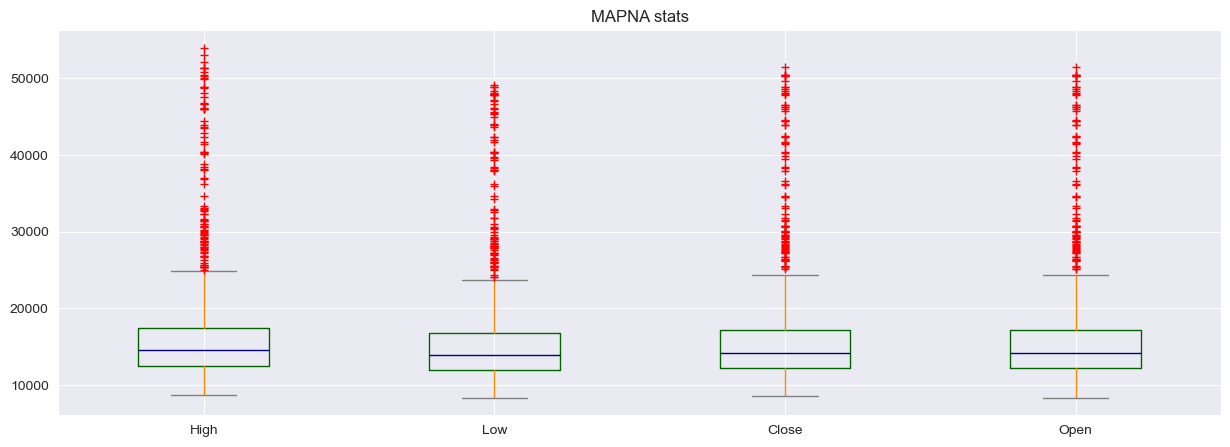

In [4]:
stock_holder.describe_plot(SAMPLE_STOCK_NAME)

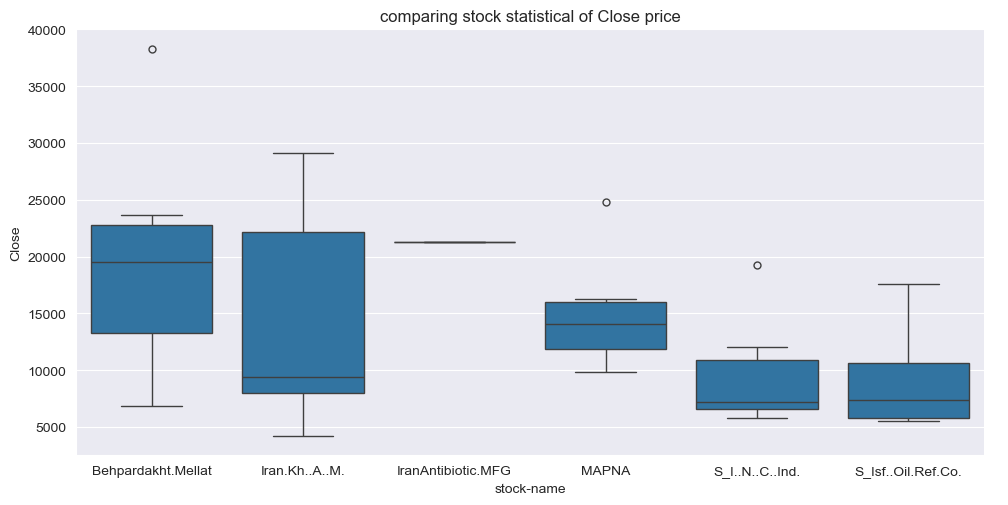

In [5]:
stock_holder.describe_together_single_col()

### closing - opening price

last 100 days

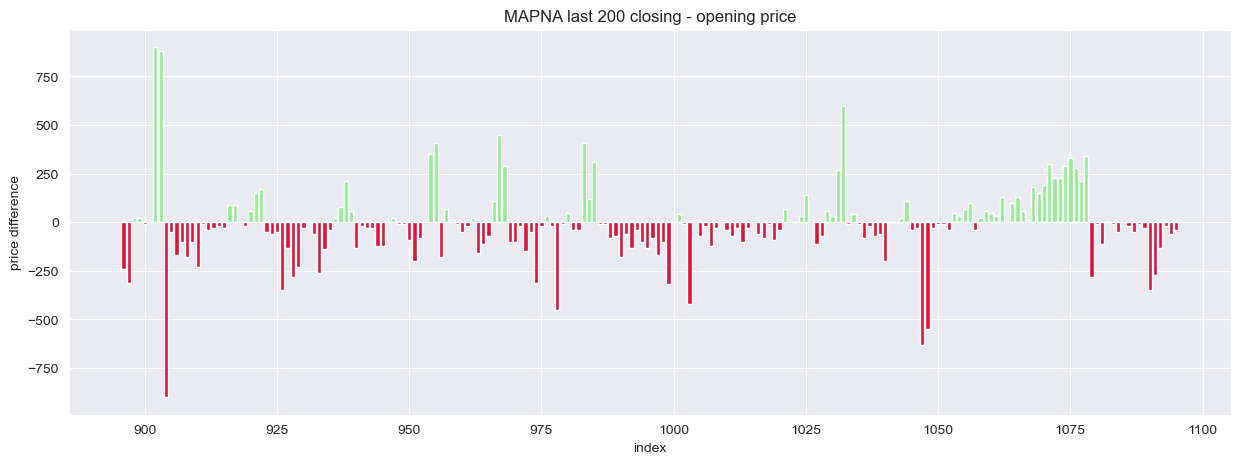

In [7]:
stock_holder.close_open_diff(SAMPLE_STOCK_NAME, period_in_day=200, is_head=False)

### year by year mean

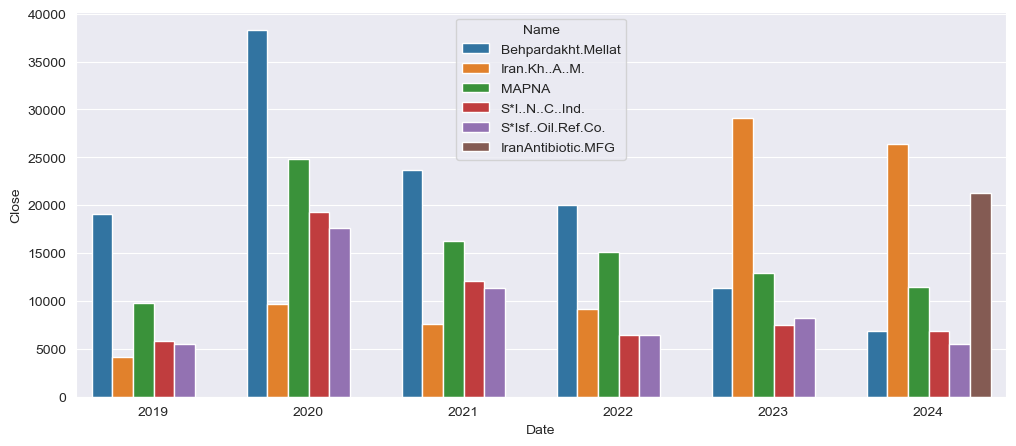

In [8]:
stock_holder.year_mean_compare()

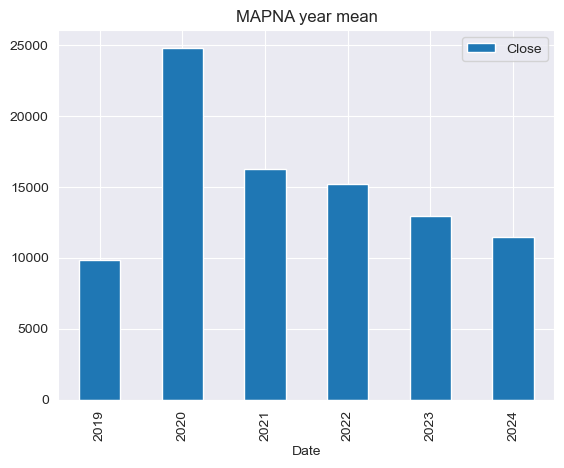

In [9]:
stock_holder.year_mean(SAMPLE_STOCK_NAME)

#### each year mean - average of last five years

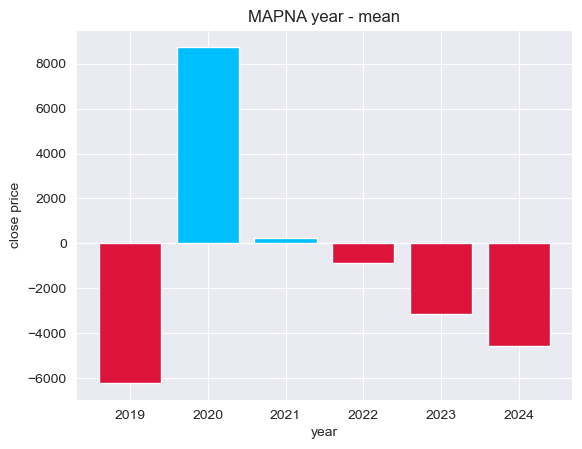

In [10]:
stock_holder.year_mean_diff(SAMPLE_STOCK_NAME)

### Data visualization

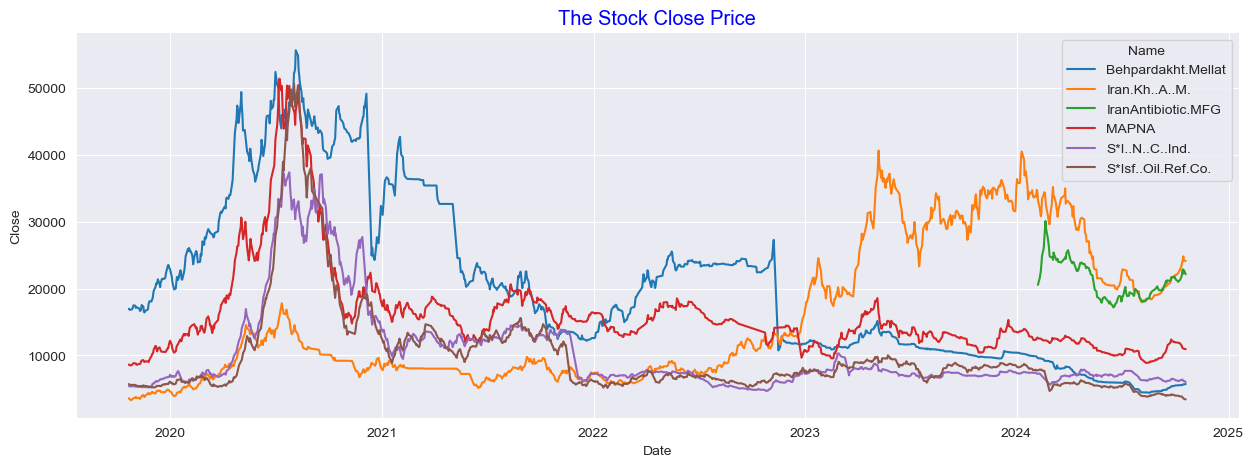

In [4]:
stock_holder.data_plot_compare('Close')

single stock

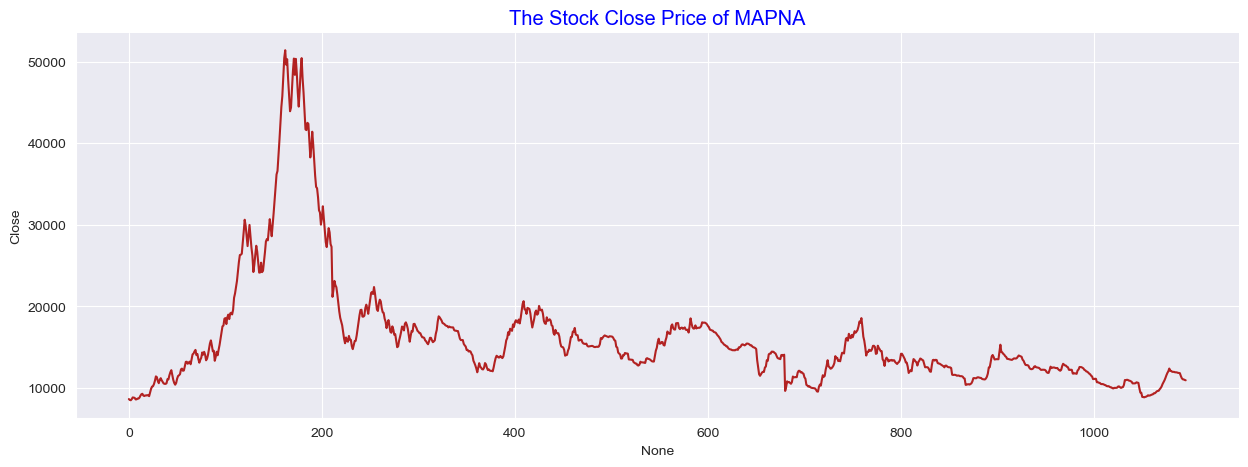

In [6]:
stock_holder.data_plot_single_stock(SAMPLE_STOCK_NAME, is_number_index=True) # change it to false in order to get date index

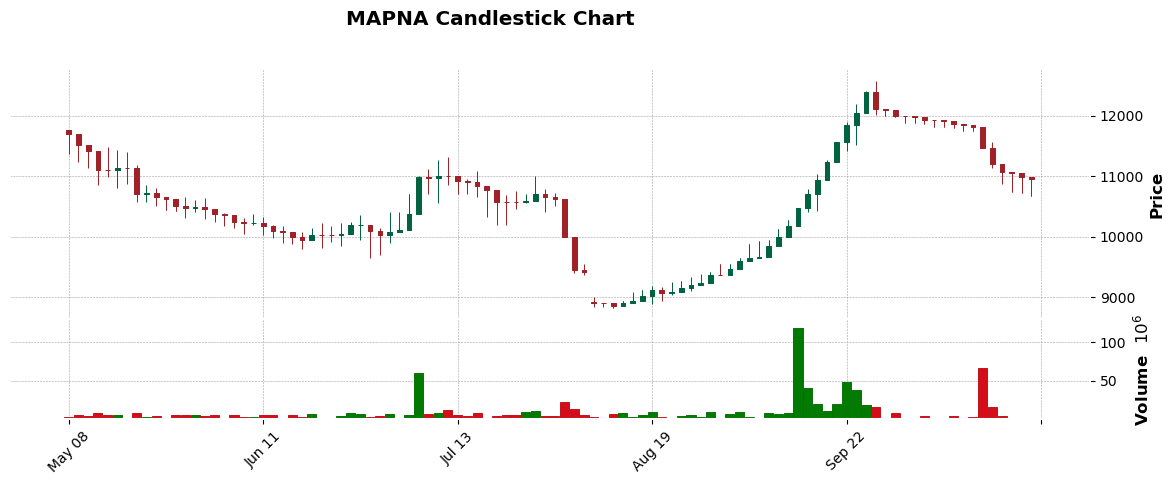

             Name       Date     High      Low    Close    Volume     Open
Date                                                                      
2024-10-13  MAPNA 2024-10-13  11560.0  11130.0  11200.0  15671221  11470.0
2024-10-14  MAPNA 2024-10-14  11190.0  10870.0  11070.0   4432100  11200.0
2024-10-15  MAPNA 2024-10-15  10740.0  10740.0  11050.0    750361  11070.0
2024-10-16  MAPNA 2024-10-16  10720.0  10720.0  10990.0   1729490  11050.0
2024-10-19  MAPNA 2024-10-19  10670.0  10670.0  10950.0   1500022  10990.0


In [4]:
stock_holder.mpf_last_days_view(SAMPLE_STOCK_NAME, days=100)

In [ ]:
resolve error and make simulations

In [1]:
from backtest.simulator.bakctest_simulator import BackTestSimulator
from stock_holder import StockHolder


stock_holder = StockHolder()

sim = BackTestSimulator(stock_holder.get_samples(), stock_holder.get_stock_names(), [(10, 20), (10, 30), (20, 50), (20, 30)])
sim.simulate()

AttributeError: 'NoneType' object has no attribute '_next_stid'

In [18]:
import backtrader as bt
import datetime
import yfinance as yf
import matplotlib.pyplot as plt

# Fetch data using yfinance
data_df = yf.download('RELIANCE.NS', start='2020-01-01', end='2024-01-01')

# Create a custom pandas feed to use with Backtrader
class PandasData(bt.feeds.PandasData):
    params = (
        ('fromdate', datetime.datetime(2020, 1, 1)),
        ('todate', datetime.datetime(2023, 1, 1)),
        ('open', 'Open'),
        ('high', 'High'),
        ('low', 'Low'),
        ('close', 'Close'),
        ('volume', 'Volume'),
        ('openinterest', None),  # No open interest in Yahoo data
    )

# Define the EMA Crossover Strategy
class EmaCrossStrategy(bt.Strategy):
    params = (('short_period', 10), ('long_period', 20),)

    def __init__(self):
        # Initialize the 10-day and 20-day EMA indicators
        self.ema_short = bt.indicators.EMA(self.data.close, period=self.params.short_period)
        self.ema_long = bt.indicators.EMA(self.data.close, period=self.params.long_period)
        self.trade_list = []  # To keep track of trades

    def next(self):
        if not self.position:  # Check if we are not in a position
            if self.ema_short < self.ema_long:  # Buy if short EMA crosses above long EMA
                self.buy()
        else:
            if self.ema_short > self.ema_long:  # Sell if short EMA crosses below long EMA
                self.sell()

    def notify_trade(self, trade):
        if trade.isclosed:
            exit_price = None
            if trade.size != 0:
                exit_price = trade.price + trade.pnlcomm / trade.size  # Calculate exit price
            else:
                exit_price = trade.price  # Set exit price to entry price if size is zero (or handle as needed)

            # Log the trade details when a trade is closed
            trade_details = {
                'Entry Price': trade.price,  # Entry price of the trade
                'Exit Price': exit_price,  # Calculated exit price
                'Size': trade.size,  # Size of the trade
                'Profit/Loss': trade.pnlcomm  # Net PnL after commission
            }
            self.trade_list.append(trade_details)


    def notify_order(self, order):
        if order.status in [order.Completed]:
            if order.isbuy():
                print(f"Buy Executed: Price: {order.executed.price}, Size: {order.executed.size}")
            elif order.issell():
                print(f"Sell Executed: Price: {order.executed.price}, Size: {order.executed.size}")
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            print("Order Failed")

    def stop(self):
        # Print list of trades
        print("List of Trades:")
        for trade in self.trade_list:
            print(trade)
        print("\n")

# Create an instance of Cerebro engine
cerebro = bt.Cerebro()

# Add the strategy to Cerebro
cerebro.addstrategy(EmaCrossStrategy)

# Convert the DataFrame into a Backtrader-compatible data feed
data_feed = PandasData(dataname=data_df)

# Add the data feed to Cerebro
cerebro.adddata(data_feed)

# Set initial capital and commissions
cerebro.broker.setcash(300000)  # Rs 3,00,000 starting capital
cerebro.broker.setcommission(commission=0.002 / 100)  # 0.002% commission on turnover

# Print the starting portfolio value
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run the backtest
results = cerebro.run()

# Print the final portfolio value
final_value = cerebro.broker.getvalue()
print('Final Portfolio Value: %.2f' % final_value)

# Calculate Profit/Loss and other metrics
profit_loss = final_value - 300000
print('Net Profit/Loss: %.2f' % profit_loss)

# Plot the results
fig = cerebro.plot(iplot=False, figsize=(15,5))[0][0]

[*********************100%***********************]  1 of 1 completed

Starting Portfolio Value: 300000.00
Buy Executed: Price: 1347.7720947265625, Size: 1
Sell Executed: Price: 1094.501953125, Size: -1
Buy Executed: Price: 2011.21630859375, Size: 1
Sell Executed: Price: 1853.337158203125, Size: -1
Buy Executed: Price: 1834.92333984375, Size: 1
Sell Executed: Price: 1839.9998779296875, Size: -1
Buy Executed: Price: 1772.620849609375, Size: 1
Sell Executed: Price: 1865.7515869140625, Size: -1
Buy Executed: Price: 1748.438232421875, Size: 1
Sell Executed: Price: 1897.225830078125, Size: -1
Buy Executed: Price: 1903.17919921875, Size: 1
Sell Executed: Price: 1844.06103515625, Size: -1
Buy Executed: Price: 1934.8380126953125, Size: 1
Sell Executed: Price: 1954.2672119140625, Size: -1
Buy Executed: Price: 2313.083251953125, Size: 1
Sell Executed: Price: 2262.456787109375, Size: -1
Buy Executed: Price: 2182.894287109375, Size: 1
Sell Executed: Price: 2226.275146484375, Size: -1
Buy Executed: Price: 2127.51416015625, Size: 1
Sell Executed: Price: 2245.4274902343

<IPython.core.display.Javascript object>